## Handle Files

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# # Authenticate to access cloud bucket
# from google.colab import auth
# auth.authenticate_user()

# #create a LOCAL directory in /content/  so you can move stuff from bucket to local
# !mkdir /content/nlp_podcast_episodes_2
# # # copy from google bucket to local directory
# !gsutil -m -q cp -r -n gs://podcast_episodes/train_test/ /content/nlp_podcast_episodes_2

## Imports and Paths

In [3]:
import pandas as pd
import numpy as np
from tensorflow import convert_to_tensor
from tensorflow.keras import layers
from tensorflow.keras.metrics import Accuracy, Recall
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import json
import sys
from nltk.metrics.segmentation import windowdiff
from nltk.metrics.segmentation import pk

path = '/content/drive/MyDrive/nlp_podcast_segmentation/'
yt_path = path + 'data/YouTube/'
splits = 'yt_scripts_segments_split_n5_111422'
pooling = 'all-MiniLM-L6-v2-meanpooling' # all-MiniLM-L6-v2-meanpooling or #stsb-mpnet-base-v2-meanpooling
embed_path = yt_path + f'embeddings/{splits}/{pooling}/'
dev_dir =  path + 'scripts/john/supervised/modeling/'
train_test_path = '/content/nlp_podcast_episodes_2/train_test/'

sys.path.append(dev_dir)
from data_loader import DataGenerator

In [4]:
# Set params
max_sequence = 350
embed_dim = 384
batch_size = 128
head_size=128
num_heads=8
ff_dim=4
num_transformer_blocks=3
dropout=0.25
learning_rate=0.001
epochs = 30
c = 1

In [5]:
## Eval function
def average_sentences(topic_list):
  '''
  Counts the number of sentences between topics
  input: topic labels
  returns: average number of sentences between topics
  '''
  idx = 0
  count = 0
  sentence_counts = []
  
  while(idx < len(topic_list)):
    if(topic_list[idx] == 1):
      sentence_counts.append(count)
      count = 0
    count += 1
    idx += 1

  if len(sentence_counts) == 0:
    return 0
    
  return sum(sentence_counts) / len(sentence_counts)

## Data loaders

In [6]:
# Parameters
params = {'input_dim': (max_sequence, embed_dim),
          'output_dim': max_sequence,
          'batch_size': batch_size,
          'shuffle': True}

# Datasets
with open(f"{train_test_path}partitions.json", 'r') as f:
  partitions = json.load(f)
with open(f"{train_test_path}labels.json", 'r') as f:
  labels = json.load(f)

# Generators
train_ids = partitions['train']
test_ids = partitions['test']
training_generator = DataGenerator(train_ids, labels, train_test_path, **params)
test_generator = DataGenerator(test_ids, labels, train_test_path, **params)
print(len(train_ids), len(test_ids))

42521 1652


In [7]:
## TEST LABELS
# Prepare test inputs, labels
test_size = len(test_ids)
X_test = np.empty((test_size, max_sequence, embed_dim))
k_test = []
y_test = []
y_test_list = np.empty((test_size, max_sequence), dtype=str)

for i, ID in enumerate(test_ids):
  X_test[i] = np.load(f"{train_test_path}{ID}.npy")
  y_test_list[i] = np.array(labels[ID], dtype='uint8')
  y_test.append(''.join(str(z) for z in labels[ID]))
  k_test.append(int(average_sentences(np.array(labels[ID], dtype='uint8'))/2))

In [8]:
# Loop through batches to get label counts
pos = 0
neg = 0
for ID in partitions['train']:
  pos += np.sum(labels[ID])
  neg += len(labels[ID]) - np.sum(labels[ID])
total = pos + neg
print(f"Pos rate: {pos/total}, Neg rate: {neg/total}, Total: {total}")

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
initial_bias = np.log([pos/neg])
print(f"Initial Bias: {initial_bias}")
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

pos_weight = c*weight_for_1/weight_for_0
print(f"Pos_weight: {pos_weight}")

Pos rate: 0.04250545108803381, Neg rate: 0.9574945489119662, Total: 14882350
Initial Bias: [-3.1146877]
Weight for class 0: 0.52
Weight for class 1: 11.76
Pos_weight: 22.526394248325516


## Baseline Model (Simple RNN)

In [9]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [10]:
def create_rnn_model(max_sequence_length=1000,
                     embed_dim = 384,
                     head_size=256,
                     num_heads=4,
                     ff_dim=8,
                     num_transformer_blocks=4,
                     dropout=0.10,
                     learning_rate=0.001,
                     #output_bias=np.log(0.05/0.95),
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
                     ):

  ## Build model
  input_layer = tf.keras.layers.Input(
      shape=(max_sequence_length, embed_dim), dtype='float32')
  x = input_layer
  # Transformer encoders
  for _ in range(num_transformer_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

  # Pool
  #x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

  # Decode
  dense1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2',
                                 name='dense_1')(x)
  drop1 = tf.keras.layers.Dropout(dropout)(dense1)
  dense2 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l2',
                                 name='dense_2')(dense1)
  drop2 = tf.keras.layers.Dropout(dropout)(dense2)                
  output = tf.keras.layers.Dense(1, activation='sigmoid',
                                 name='segment_classifier')(dense2)
  
  # Build
  rnn_model = tf.keras.models.Model(inputs=input_layer, outputs=[output])
  rnn_model.compile(loss=loss,
                    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics=[tf.keras.metrics.Recall(), 
                             tf.keras.metrics.BinaryAccuracy()]
                    )

  return rnn_model

In [11]:
# Eventual loss function strucutre
def my_loss(weight):
  def weighted_cross_entropy_with_logits(labels, logits):
    labels = tf.cast(labels, 'float32')
    #logits = tf.where(tf.less(logits, 0), 0., logits) # prevents odd error of pred < 0
    loss = tf.nn.weighted_cross_entropy_with_logits(
        labels, logits, weight
    )
    return loss
  return weighted_cross_entropy_with_logits

## LR Scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001)

In [64]:
rnn_model = create_rnn_model(max_sequence_length=max_sequence,
                              embed_dim=embed_dim,
                              head_size=head_size,
                              num_heads=4,
                              ff_dim=ff_dim,
                              num_transformer_blocks=num_transformer_blocks,
                              dropout=dropout,
                              learning_rate=learning_rate,
                              loss=my_loss(weight=pos_weight)
                              )


## Train

In [13]:
rnn_history = rnn_model.fit(training_generator,
                            validation_data=test_generator,
                            epochs=epochs,
                            callbacks=[reduce_lr],
                            )

Epoch 1/30
332/332 [==============================] - 57s 152ms/step - loss: 1.5825 - recall: 0.2914 - binary_accuracy: 0.8938 - val_loss: 1.1860 - val_recall: 0.3465 - val_binary_accuracy: 0.8623 - lr: 0.0010
Epoch 2/30
332/332 [==============================] - 50s 150ms/step - loss: 1.2276 - recall: 0.4309 - binary_accuracy: 0.8841 - val_loss: 1.1857 - val_recall: 0.2832 - val_binary_accuracy: 0.8922 - lr: 0.0010
Epoch 3/30
332/332 [==============================] - 50s 150ms/step - loss: 1.2244 - recall: 0.4382 - binary_accuracy: 0.8850 - val_loss: 1.1902 - val_recall: 0.2788 - val_binary_accuracy: 0.8909 - lr: 0.0010
Epoch 4/30
332/332 [==============================] - 50s 150ms/step - loss: 1.2272 - recall: 0.4328 - binary_accuracy: 0.8839 - val_loss: 1.1884 - val_recall: 0.2646 - val_binary_accuracy: 0.8995 - lr: 0.0010
Epoch 5/30
332/332 [==============================] - 50s 150ms/step - loss: 1.2275 - recall: 0.4404 - binary_accuracy: 0.8798 - val_loss: 1.1933 - val_recall: 

## Evaluate

In [18]:
# MAE functions
def mae_std(y_true, y_pred):
  ep_ref_tc = tf.reduce_sum(np.array(y_true, dtype='int'), axis=1).numpy()
  ep_pred_tc = tf.reduce_sum(np.array(y_pred, dtype='int'), axis=1).numpy()
  ep_diff = np.abs(ep_ref_tc - ep_pred_tc)
  ep_rel_diff = ep_diff/ep_ref_tc
  mae_std = np.mean(ep_rel_diff)

  return mae_std, ep_rel_diff

# Remove back to back transition preds (keep last one in bb set)
def remove_bb_preds(y_pred_bin_int):
  for ep_num in range(len(y_pred_bin_int)):
    pos_inds = np.where(np.array(y_pred_bin_int[ep_num])==1)[0]
    for i in range(1, len(pos_inds)):
      if pos_inds[i-1] == (pos_inds[i]-1):
        y_pred_bin_int[ep_num][pos_inds[i-1]] = 0 #set left ind to zero

  return y_pred_bin_int


def eval_preds(preds, thresh):
  preds_bin_int = [[1 if x > thresh else 0 for x in p.reshape(-1)] for p in preds]
  preds_bin_int = remove_bb_preds(preds_bin_int)
  preds_bin_str = [''.join(str(a) for a in z) for z in preds_bin_int]

  # Get PK, WD
  pk_metrics = []
  wd_metrics = []
  for i in range(test_size):
    pk_metric = pk(preds_bin_str[i], y_test[i], k=k_test[i])
    wd = windowdiff(preds_bin_str[i], y_test[i], k=k_test[i])
    pk_metrics.append(pk_metric)
    wd_metrics.append(wd)

  # Get MAE
  mae, ep_rel_diff = mae_std(y_test_list, preds_bin_int)

  print(f"\nThreshold: {thresh}")
  print(f"PK Mean: {np.mean(pk_metrics)}")
  print(f"WD Mean: {np.mean(wd_metrics)}")
  print(f"MAE    : {round(mae, 3)}")

  return preds_bin_str, pk_metrics, wd_metrics, mae, ep_rel_diff

In [28]:
preds = rnn_model.predict(X_test)
preds_bin, pk_metrics, wd_metrics, mae, ep_rel_diff = eval_preds(preds, thresh=0.999)

52/52 [==============================] - 1s 17ms/step

Threshold: 0.999
PK Mean: 0.33062167746512316
WD Mean: 0.371988197517762
MAE    : 0.624


In [68]:
# preds = rnn_model.predict(X_test)
# thresholds = [0.25, 0.5, 0.6, 0.65, 0.75, 0.9 , 0.99, 0.999, 0.99999999999]
# for thresh in thresholds:
#   preds_bin, pk_metrics, wd_metrics, mae, ep_rel_diff = eval_preds(preds, thresh)

In [69]:
# start = 70
# n = 5
# thresh = 0.999
# preds_bin, pk_metrics, wd_metrics, mae, ep_rel_diff = eval_preds(preds, thresh)
# print(f"\nThreshold: {thresh} - 3 examples below:")
# for i in range(start, start+n):
#   print(f"\nPred  : {preds_bin[i]}")
#   print(f"Actual: {y_test[i]}")
#   print(f"K value: {k_test[i]}")
#   print(f"PK value: {pk_metrics[i]}")
#   print(f"WD value: {wd_metrics[i]}")

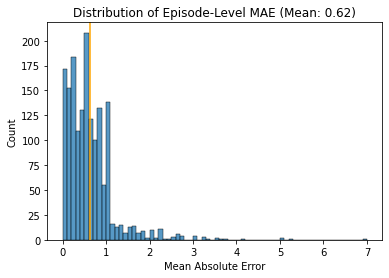

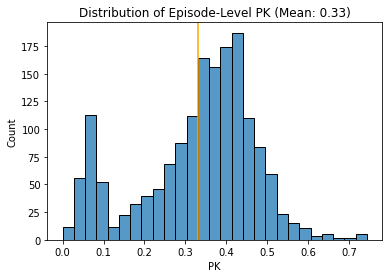

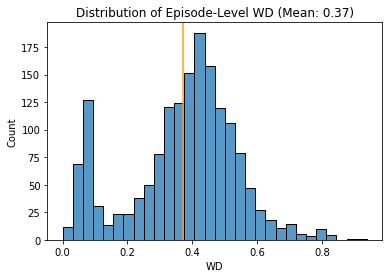

In [67]:
## Eval Charts
fig, ax = plt.subplots()
sns.histplot(ep_rel_diff)
plt.axvline(mae, 0, 250, color='orange')
plt.title(f'Distribution of Episode-Level MAE (Mean: {round(mae, 2)})')
plt.xlabel('Mean Absolute Error')
plt.show()

fig, ax = plt.subplots()
sns.histplot(pk_metrics)
plt.axvline(np.mean(pk_metrics), 0, 250, color='orange')
plt.title(f'Distribution of Episode-Level PK (Mean: {round(np.mean(pk_metrics), 2)})')
plt.xlabel('PK')
plt.show()

fig, ax = plt.subplots()
sns.histplot(wd_metrics)
plt.axvline(np.mean(wd_metrics), 0, 250, color='orange')
plt.title(f'Distribution of Episode-Level WD (Mean: {round(np.mean(wd_metrics), 2)})')
plt.xlabel('WD')
plt.show()

In [59]:
good_pred_inds = np.where(np.array(wd_metrics) < 0.1)[0]
preds_bin_int = [[1 if x > thresh else 0 for x in p.reshape(-1)] for p in preds]
n = 5
for i in range(n):
  ind = good_pred_inds[i]
  print(f"\nPred  : {preds_bin[ind]}")
  print(f"Actual: {y_test[ind]}")
  print(f"K value: {k_test[ind]}")
  print(f"Num topics: {np.sum(np.array(y_test_list[ind]).astype(int))}")
  print(f"Pred topics: {np.sum(np.array(preds_bin_int[ind]))}")
  print(f"PK value: {pk_metrics[ind]}")
  print(f"WD value: {wd_metrics[ind]}")


Pred  : 00000000000000010010000000001000000001000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Actual: 10000010000000010000000000001000000100000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
K value: 3
Num topics: 6
Pred topics: 5
PK value: 0.03735632183908046
WD value: 0.03735632183908046

Pred  : 0000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000